In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.io.json import json_normalize
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from scipy.stats import skew, kurtosis, entropy, iqr, median_abs_deviation
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from math import sqrt
import sklearn.metrics as metrics
import sklearn.metrics as sm
from sklearn.model_selection import GridSearchCV

In [3]:
def open_datos(url):
    with open(url, 'r') as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)
    return df


def find_signals(time_series):
    start_index = None
    max_abs_val = None
    signals = []
    
    for i, value in enumerate(time_series):
        if start_index is None and value <= -0.06:
            start_index = i
            max_abs_val = value
        elif start_index is not None:
            if value < max_abs_val:
                max_abs_val = value
            
            if value >= 0.03:
                signals.append((start_index, i, max_abs_val))
                start_index = None
                max_abs_val = None
    
    df = pd.DataFrame(signals, columns=['Start index', 'End index', 'Maximum Abs Value'])
    df["Duracion_Trade"]=df["End index"]-df["Start index"]
    return df

In [4]:
data=pd.read_csv("/Users/rogarciag/Desktop/AI_&_TRADING/ALGORITHMIC_TRADING/PRINCIPAL/NASINI/TRABAJOS_GENERAL/PROYECTO_TRADING/BASES_DE_DATOS/DATOS_CSV/AL30_COMPLETE_TASAS.csv")

In [28]:
time_series = pd.DataFrame(columns=['date','spread'])
# modifiique los nombres así era más claro

#APLICAR EXPONENTE HURST
data["SPREAD_COLOCAR_PLAZO_CERCANO"] = data["COLOCAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)
data["SPREAD_COLOCAR_PLAZO_LEJANO"] = data["COLOCAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)

data["SPREAD_TOMAR_PLAZO_CERCANO"] =data["TOMAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100) 
data["SPREAD_TOMAR_PLAZO_LEJANO"] = data["TOMAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)

data_general=data[["caucion_a_un_dia_ultimo_trade_tasa","SPREAD_COLOCAR_PLAZO_CERCANO","SPREAD_COLOCAR_PLAZO_LEJANO","SPREAD_TOMAR_PLAZO_CERCANO","SPREAD_TOMAR_PLAZO_LEJANO"]]

threshold_arbitrage=0

for index, row in data_general.iterrows():
    #Elegimos el mejor spread para colocar y tomar
    if  row["SPREAD_COLOCAR_PLAZO_CERCANO"] > row["SPREAD_COLOCAR_PLAZO_LEJANO"]:
         spread_colocar = row["SPREAD_COLOCAR_PLAZO_CERCANO"]
    else:
        spread_colocar = row["SPREAD_COLOCAR_PLAZO_LEJANO"]

    if row["SPREAD_TOMAR_PLAZO_CERCANO"] < row["SPREAD_TOMAR_PLAZO_LEJANO"]:
        spread_tomar = row["SPREAD_TOMAR_PLAZO_CERCANO"]

    else:
        spread_tomar = row["SPREAD_TOMAR_PLAZO_LEJANO"]

    # CASO NO PASA NADA
    if row["SPREAD_COLOCAR_PLAZO_CERCANO"] < threshold_arbitrage and row["SPREAD_COLOCAR_PLAZO_LEJANO"] < threshold_arbitrage  and row["SPREAD_TOMAR_PLAZO_CERCANO"] > threshold_arbitrage and row["SPREAD_TOMAR_PLAZO_LEJANO"] > threshold_arbitrage:
        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[0]})],ignore_index=True)
        
    elif spread_colocar > 0 and spread_tomar < 0:

        if spread_colocar > -spread_tomar:
            
            time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_colocar]})],ignore_index=True)
        
        else:

            time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_tomar]})],ignore_index=True)

    elif spread_colocar > 0:

        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_colocar]})],ignore_index=True)

    elif spread_tomar < 0:

        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_tomar]})],ignore_index=True)
    else:
        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[0]})],ignore_index=True)

In [29]:
x=time_series["spread"]
y=data_general=data[["SPREAD_COLOCAR_PLAZO_CERCANO","SPREAD_COLOCAR_PLAZO_LEJANO","SPREAD_TOMAR_PLAZO_CERCANO","SPREAD_TOMAR_PLAZO_LEJANO"]]

# PRUEBAS VARIANZA GENERAL

In [30]:
import pandas as pd

data = y
short_window = 10 # Define the short-term window
long_window = 60   # Define the long-term window

# Calculate the rolling variance for each column
data["SPREAD_COLOCAR_PLAZO_CERCANO_VAR_SHORT"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=short_window).var()
data["SPREAD_COLOCAR_PLAZO_LEJANO_VAR_SHORT"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=short_window).var()
data["SPREAD_TOMAR_PLAZO_CERCANO_VAR_SHORT"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=short_window).var()
data["SPREAD_TOMAR_PLAZO_LEJANO_VAR_SHORT"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=short_window).var()

data["SPREAD_COLOCAR_PLAZO_CERCANO_VAR_LONG"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=long_window).var()
data["SPREAD_COLOCAR_PLAZO_LEJANO_VAR_LONG"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=long_window).var()
data["SPREAD_TOMAR_PLAZO_CERCANO_VAR_LONG"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=long_window).var()
data["SPREAD_TOMAR_PLAZO_LEJANO_VAR_LONG"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=long_window).var()

data["SCORE"] = 0

# Compare the short-term and long-term variances
data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_VAR_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_CERCANO_VAR_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_VAR_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_LEJANO_VAR_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_VAR_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_VAR_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_VAR_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_VAR_LONG"].quantile(0.65), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_VAR_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_VAR_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_VAR_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_VAR_LONG"].quantile(0.80), "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_VAR_SHORT"] >= data["SPREAD_TOMAR_PLAZO_CERCANO_VAR_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_VAR_SHORT"] >= data["SPREAD_TOMAR_PLAZO_LEJANO_VAR_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_VAR_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_VAR_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_VAR_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_VAR_LONG"].quantile(0.65), "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_VAR_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_VAR_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_VAR_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_VAR_LONG"].quantile(0.80), "SCORE"] += 1

data.dropna(inplace=True)

In [31]:
final_df=pd.DataFrame()
final_df["Total_Spread"]=x
final_df["Total_Score_Parametro_1_negativo"]=data["SCORE"]

time_series = final_df["Total_Spread"]
result = find_signals(time_series)

df_1 = result
df_2 = final_df["Total_Score_Parametro_1_negativo"]
indices = df_1["Start index"].values
df_score_spread = df_2.loc[indices]

df_score_filtrado=pd.DataFrame(df_score_spread)
result["Score_Inicio_Trade"]=df_score_filtrado["Total_Score_Parametro_1_negativo"].values

result_sorted = result.sort_values('Maximum Abs Value', ascending=True)
result_sorted.dropna(inplace=True)

result_sorted

,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
2,240,1549,-3.311920,1309,5.0
8,2615,3503,-3.006852,888,3.0
6,1571,2506,-1.358197,935,6.0
33,5326,5587,-1.087408,261,0.0
4,1554,1563,-0.871009,9,12.0
32,4952,5324,-0.631199,372,2.0
5,1565,1570,-0.399987,5,8.0
10,3528,3655,-0.377281,127,10.0
7,2507,2608,-0.376510,101,8.0
18,3719,4444,-0.361816,725,0.0


In [32]:
result_filter=result_sorted[result_sorted["Duracion_Trade"]<50]
result_filter


,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
4,1554,1563,-0.871009,9,12.0
5,1565,1570,-0.399987,5,8.0
9,3507,3527,-0.357448,20,6.0
14,3683,3692,-0.241893,9,7.0
12,3669,3671,-0.212930,2,3.0
3,1551,1552,-0.211301,1,12.0
13,3672,3681,-0.199302,9,1.0
11,3658,3667,-0.196181,9,5.0
30,4934,4944,-0.167277,10,0.0
21,4765,4777,-0.152074,12,0.0


<Axes: >

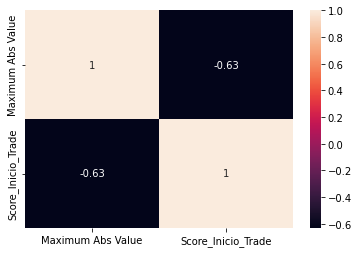

In [33]:
sns.heatmap(result_filter[["Maximum Abs Value","Score_Inicio_Trade"]].corr(),annot=True)

In [34]:
x=result_filter[['Maximum Abs Value']]
y=result_filter['Score_Inicio_Trade']

sc=StandardScaler().fit(x)
x_sc=sc.transform(x)

lm=LinearRegression()
lm.fit(x_sc, y)
predictions=lm.predict(x_sc)

print("Mean absolute error =", round(sm.mean_absolute_error(y, predictions), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, predictions), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, predictions), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, predictions), 2)) 
print("R2 score =", round(sm.r2_score(y, predictions), 2))

Mean absolute error = 2.39
Mean squared error = 10.39
Median absolute error = 1.77
Explain variance score = 0.4
R2 score = 0.4
